# **Image Caption Generator with Attention** 

### Importing Libraries

In [5]:
import time 
import warnings

import pickle
import h5py
import os
from tqdm.notebook import tqdm

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras

from keras.callbacks import TensorBoard
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Activation, Dropout,
    GRU, Bidirectional, LSTM,
    Add, add,
    AdditiveAttention,
    Attention,
    Concatenate, concatenate,
    Embedding,
    LayerNormalization,
    Dense,
    Reshape,
)
from sklearn.model_selection import train_test_split, KFold

from keras.layers.experimental.preprocessing import StringLookup
from keras.layers.experimental.preprocessing import TextVectorization

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

from textwrap import wrap

from tensorflow.python.client import device_lib
print(tf.version.VERSION)
print(device_lib.list_local_devices())

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2.13.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7635813935567498965
xla_global_id: -1
]


2023-10-14 18:18:34.822068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-10-14 18:18:34.822177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mr-freak
2023-10-14 18:18:34.822189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mr-freak
2023-10-14 18:18:34.822374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2023-10-14 18:18:34.822403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-10-14 18:18:34.822410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.113.1


### Configurations

In [6]:
DATA_DIR = '/home/jerlshin/Documents/My_Work/__DATASET__/flickr8k/'

IMAGE_DIR = os.path.join(DATA_DIR, 'images/')
CAPTIONS_DIR = os.path.join(DATA_DIR, 'captions.txt')


class Param:    
    VOCAB_SIZE = 8485 # calculated with tokenizer 
    ATTENTION_DIM = 512
    WORD_EMBEDDDING = 128
    IMG_HEIGHT = 299
    IMG_WIDTH = 299
    IMG_CHANNELS = 3
    FEATURES_SHAPE = (8, 8, 1536) 
    
    BUFFER_SIZE = 1000
    BATCH_SIZE = 16  # reducing the batch size for latptop compatability
    MAX_CAPTION_LEN = 64


### Visualizing

In [7]:
data = pd.read_csv(CAPTIONS_DIR)


In [8]:
data['caption'][0]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [9]:
def get_image_label_example(example):
    caption = data['caption']
    img = example['image']
    img = tf.image.resize(img, (Param.IMG_HEIGHT, Param.IMG_WIDTH))
    img = img/255.
    return {"image_tensor":img, "caption": caption}

### Loading 

In [10]:
data = pd.read_csv(CAPTIONS_DIR)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


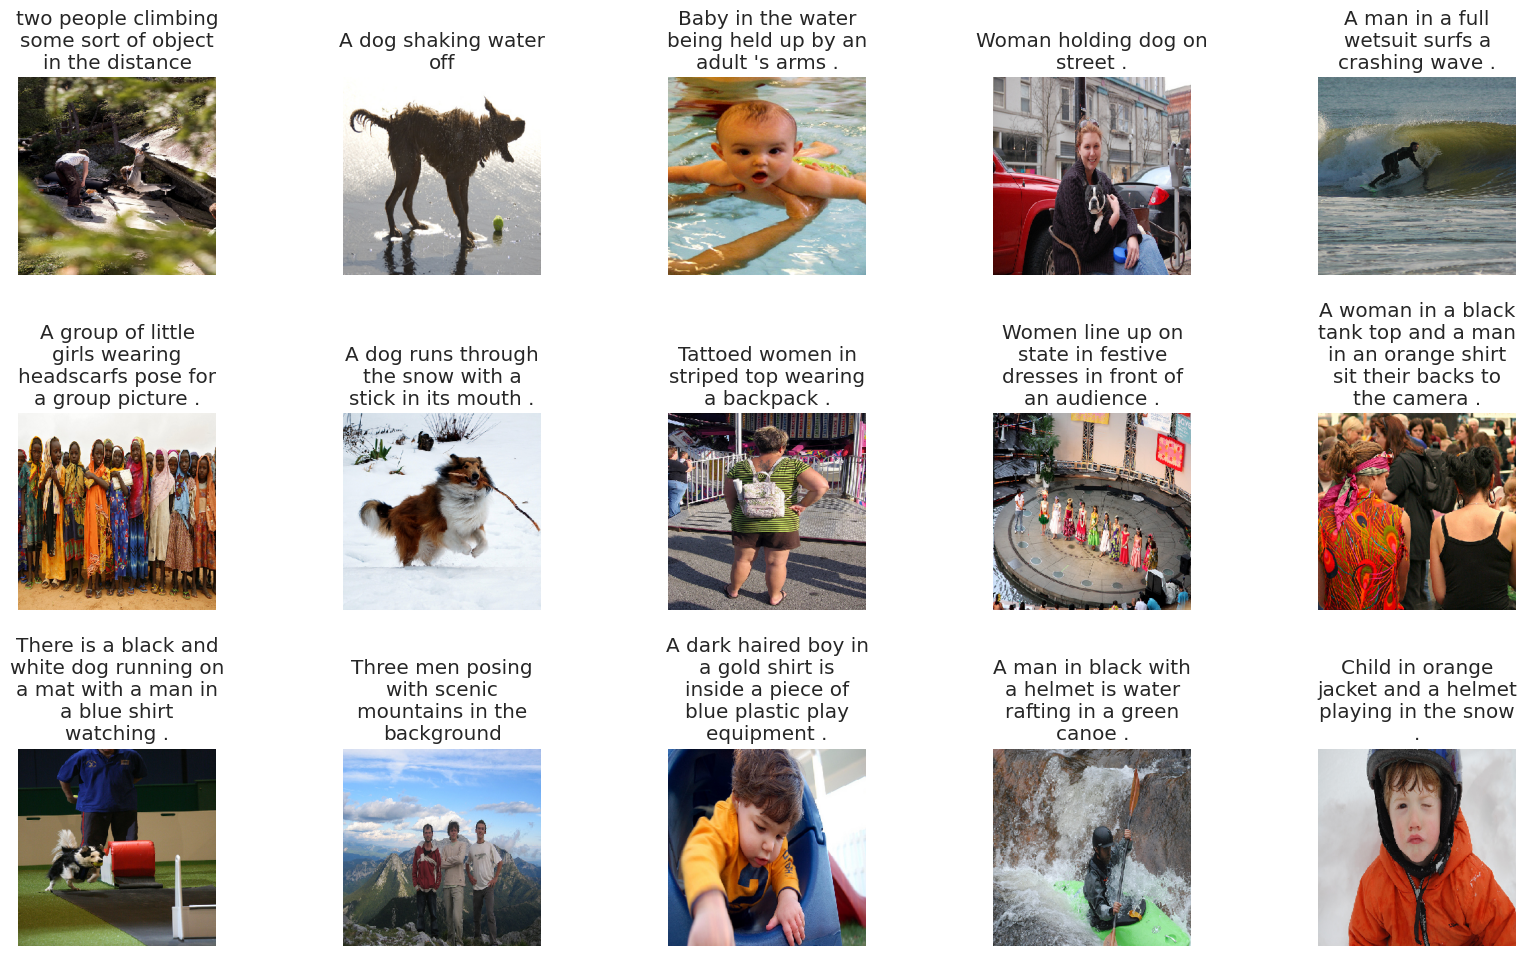

In [11]:
def readImage(path, img_size = (Param.IMG_HEIGHT, Param.IMG_WIDTH)):
    img = keras.preprocessing.image.load_img(path, color_mode='rgb', target_size=img_size)
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255.
    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(IMAGE_DIR + f'{temp_df.image[i]}')
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


display_images(data.sample(15))

### Preprocessing

In [12]:
data = pd.read_csv(CAPTIONS_DIR)

def text_preprocessig(data):
    data['caption'] = data['caption'].apply(lambda x : x.lower())
    data['caption'] = data['caption'].apply(lambda x : x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x : x.replace("/s+", ""))
    data['caption'] = data['caption'].apply(lambda x : " ".join(
        [word for word in x.split() if len(word) > 1]
    ))
    data['caption'] = "SOS " + data['caption'] + " EOS"
    return data

data = text_preprocessig(data)
captions = data['caption'].tolist()
captions[:10]

['SOS child in pink dress is climbing up set of stairs in an entry way EOS',
 'SOS girl going into wooden building EOS',
 'SOS little girl climbing into wooden playhouse EOS',
 'SOS little girl climbing the stairs to her playhouse EOS',
 'SOS little girl in pink dress going into wooden cabin EOS',
 'SOS black dog and spotted dog are fighting EOS',
 'SOS black dog and tri-colored dog playing with each other on the road EOS',
 'SOS black dog and white dog with brown spots are staring at each other in the street EOS',
 'SOS two dogs of different breeds looking at each other on the road EOS',
 'SOS two dogs on pavement moving toward each other EOS']

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [14]:
vocab_size

8485

In [15]:
len(train)

34385

In [16]:
len(test)

6070

In [17]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,SOS child in pink dress is climbing up set of ...
1,1000268201_693b08cb0e.jpg,SOS girl going into wooden building EOS
2,1000268201_693b08cb0e.jpg,SOS little girl climbing into wooden playhouse...
3,1000268201_693b08cb0e.jpg,SOS little girl climbing the stairs to her pla...
4,1000268201_693b08cb0e.jpg,SOS little girl in pink dress going into woode...


In [18]:
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )

tokenizer_tf = TextVectorization(
    max_tokens=Param.VOCAB_SIZE,
    output_sequence_length=Param.MAX_CAPTION_LEN,
)


### Feature Extractor

In [12]:
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet'
)

FEATURE_EXTRACTOR.trainable = False

In [ ]:
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(IMAGE_DIR, image), target_size=(Param.IMG_HEIGHT, Param.IMG_WIDTH))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    feature = FEATURE_EXTRACTOR.predict(img, verbose=0)
    features[image] = feature
    
with open('features.pkl', 'wb') as file:
    pickle.dump(features, file)

In [16]:
FEATURE_DIR = '/home/jerlshin/Documents/My_Work/__FEATURES__/Flickr8k-InceptionResNetv2/features.pkl'

with open(FEATURE_DIR, 'rb') as file:
    features = pickle.load(file)

In [17]:
features['1000268201_693b08cb0e.jpg']

array([[[[0.        , 0.27017352, 0.19774413, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.55209726, 0.9798247 , ..., 0.        ,
          0.        , 0.15087722],
         [0.        , 0.48230204, 1.3933132 , ..., 0.        ,
          0.09393819, 0.06135897],
         ...,
         [0.        , 0.        , 0.61585927, ..., 0.        ,
          1.7799916 , 0.        ],
         [0.        , 0.7214361 , 0.2835535 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.67598313, 0.        , ..., 0.16825742,
          0.        , 0.        ]],

        [[0.        , 0.        , 1.4729297 , ..., 0.        ,
          0.        , 0.48679745],
         [0.        , 0.        , 2.6815758 , ..., 0.29403138,
          0.        , 0.00896033],
         [0.        , 0.        , 2.8202796 , ..., 0.12468288,
          1.2081215 , 0.5830183 ],
         ...,
         [0.        , 0.95212483, 0.71782285, ..., 0.        ,
          1.2813163 , 0. 

### Data Generator

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    # parameters without default values must come before parameters with default values
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        # X1 - image feature
        # X2 - text feature
        # y - output 
        return (X1, X2), y
    
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
        
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y
    

train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=IMAGE_DIR,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=IMAGE_DIR,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

### **Dataset**

In [20]:
# load all the paths of the images
image_file_paths_load = [os.path.join(IMAGE_DIR, image) for image in data['image']]

def preprocess_captions(captions, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

captions_processed = preprocess_captions(data['caption'], tokenizer, Param.MAX_CAPTION_LEN)

dataset = tf.data.Dataset.from_tensor_slices((image_file_paths_load, captions_processed))

def load_and_preprocess_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=Param.IMG_CHANNELS)
    img = tf.image.resize(img, (Param.IMG_HEIGHT, Param.IMG_WIDTH))
    img = img/255.0
    return img, caption


def load_and_preprocess_image_wrapper(image_path, caption):
    img, caption = load_and_preprocess_image(image_path, caption)
    return img, caption


BASE_MODEL = tf.keras.applications.InceptionResNetV2(
    weights='imagenet', include_top=False,
    input_shape=(Param.IMG_HEIGHT, Param.IMG_WIDTH, Param.IMG_CHANNELS)
)

BASE_MODEL.trainable = False

def extract_image_features(image):
    img = tf.expand_dims(image, axis=0)  # Add batch dimension
    image_features = BASE_MODEL(img)  # (batch_size, 8, 8, 1536)
    image_features = tf.reshape(tensor=image_features, shape=(-1, image_features.shape[3]))
    return image_features  # (64, 1536)


dataset = dataset.map(load_and_preprocess_image_wrapper)

dataset = dataset.shuffle(Param.BUFFER_SIZE).batch(Param.BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
len(dataset) ## 1265 * 32 = total dataset.

2529

### viewing the Dataset

Captions:
sos boy is jumping off the side of running stone water fountain in front of building eos


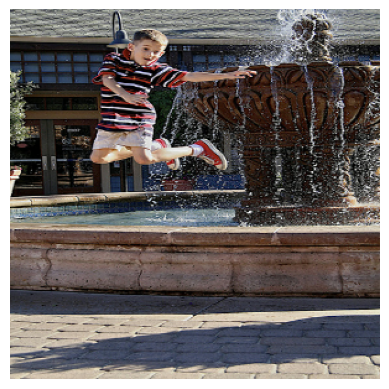

In [22]:
sample_image, sample_captions = next(iter(dataset.take(1)))

sample_image = (sample_image[0] * 255).numpy().astype('uint8')  # Assuming the image was normalized during preprocessing

sample_captions = tokenizer.sequences_to_texts(sample_captions.numpy())

print("Captions:")
for caption in sample_captions:
    print(caption)
    break
    
# Display the imag
plt.imshow(sample_image)
plt.axis('off')
plt.show()


Image Batch Shape: (16, 299, 299, 3)
Caption Shape: (16, 64)
--------------------------------------------------
Processed Caption:

tf.Tensor(
[  1  17   3 235  35 250  50 109   2   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int32) 

Original Caption: 

sos woman in striped shirt climbs up mountain eos


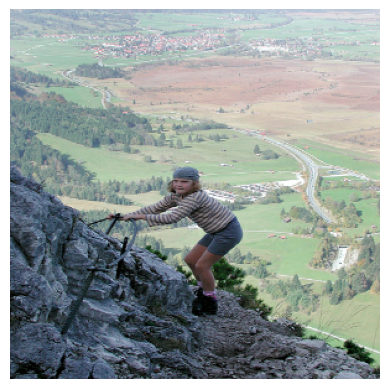

In [23]:
for img, caption in dataset.take(1):  # Take 5 samples for visualization
    img_np = img.numpy()
    
    print("Image Batch Shape:", img_np.shape)
    print("Caption Shape:", caption.shape)
    print("-" * 50)
    
    img_index = 15
    print("Processed Caption:\n")
    print(caption[img_index], '\n')
    
    plt.imshow(img_np[img_index])  # 32 images in 1 batch
    plt.axis('off')
    
    print("Original Caption: \n")
    cap = tokenizer.sequences_to_texts([caption[img_index].numpy()])[0]
    print(cap)
    plt.show()


### **Model and Training**

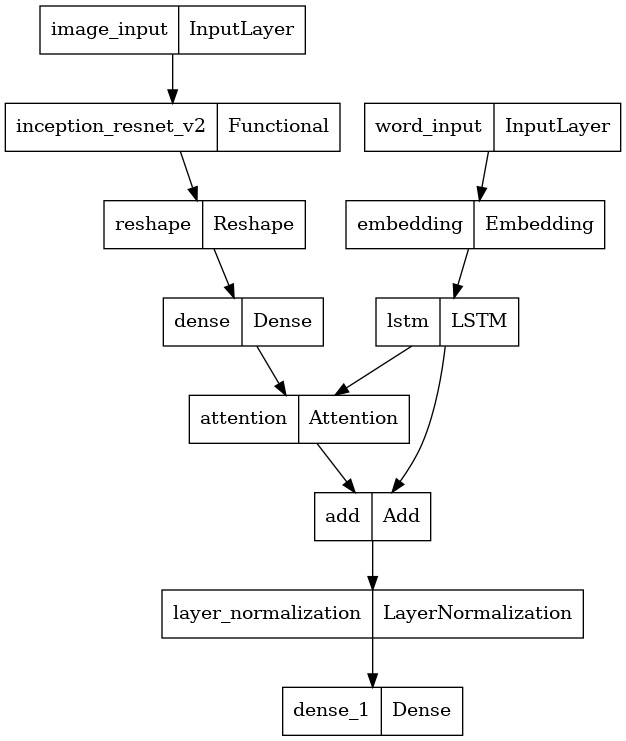

In [24]:
import tensorflow as tf
from keras.layers import Input, Dense, Embedding, LSTM, LayerNormalization, AdditiveAttention, Reshape
from keras.models import Model


BASE_MODEL.trainable = False

# Image input
image_input = Input(shape=(Param.IMG_HEIGHT, Param.IMG_WIDTH, Param.IMG_CHANNELS), name='image_input')

# Word input
word_input = Input(shape=(Param.MAX_CAPTION_LEN,), name='word_input')

# Feature extraction from images using pre-trained InceptionResNetV2
image_features = BASE_MODEL(image_input)
x = Reshape(
    target_shape=(Param.FEATURES_SHAPE[0] * Param.FEATURES_SHAPE[1], Param.FEATURES_SHAPE[2])
    )(image_features)

# Encoder
encoder_output = Dense(Param.ATTENTION_DIM, activation='relu')(x)

encoder_model = Model(inputs=image_input, 
                      outputs=encoder_output, name='encoder_model')

# Word embedding
word_embedding = Embedding(input_dim=Param.VOCAB_SIZE, output_dim=Param.ATTENTION_DIM)(word_input)

# LSTM layer
lstm_layer = LSTM(Param.ATTENTION_DIM, return_sequences=True, return_state=True)

# LSTM layer
lstm_output, lstm_state, _ = lstm_layer(word_embedding)

# Attention mechanism
context_vector = Attention()([lstm_output, encoder_output])
addition = Add()([lstm_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

# Output layer
decoder_output_dense = Dense(Param.VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

# Decoder
decoder_model = Model(inputs=[word_input, encoder_output], 
                      outputs=decoder_output, name='decoder_model')

# Generator model
Generator_Model = Model(inputs=[word_input, image_input], 
                        outputs=decoder_output, name='generator_model')

tf.keras.utils.plot_model(Generator_Model)

In [25]:
Generator_Model.summary()

Model: "generator_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 word_input (InputLayer)     [(None, 64)]                 0         []                            
                                                                                                  
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)           5433673   ['image_input[0][0]']         
 ional)                                                   6                                       
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              4344320   ['word_input[0][

In [26]:
total_samples = len(dataset)

split = 0.85
train_samples = int(split * total_samples)
val_samples = total_samples - train_samples

train_dataset = dataset.take(train_samples)
val_dataset = dataset.skip(train_samples)

print("Number of samples in training dataset:", len(train_dataset) * Param.BATCH_SIZE)
print("Number of samples in validation dataset:", len(val_dataset) * Param.BATCH_SIZE)


train_dataset = train_dataset.map(lambda image, caption: (image, caption))
val_dataset = val_dataset.map(lambda image, caption: (image, caption))


Number of samples in training dataset: 34384
Number of samples in validation dataset: 6080


In [27]:
epochs = 1
for epoch in range(epochs):
    for batch in train_dataset:
        i, c = batch
        print(i.shape)
        print(c.shape)
        break

(16, 299, 299, 3)
(16, 64)


In [28]:
for image_batch, caption_batch in train_dataset.take(1):  
    print("Image batch shape:", image_batch.shape)
    print("Caption batch shape:", caption_batch.shape)


Image batch shape: (16, 299, 299, 3)
Caption batch shape: (16, 64)


In [29]:
for image_batch, caption_batch in val_dataset.take(1):  
    print("Image batch shape:", image_batch.shape)
    print("Caption batch shape:", caption_batch.shape)


Image batch shape: (16, 299, 299, 3)
Caption batch shape: (16, 64)


In [ ]:
epochs = 10
steps_per_epochs = len(train_dataset)
validation_steps = len(val_dataset)

optimizer = Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def loss_funtion(real, pred):
    mask = tf.math.logical_not(tf.math.equal(caption, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

summary_writer = tf.summary.create_file_writer("logs")

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for batch in train_dataset:
        images, captions = batch # 32 set of images and captions
        
        with tf.GradientTape() as tape:
            predictions = Generator_Model([captions, images], training = True)
            mask = tf.math.logical_not(tf.math.equal(caption, 0))
            loss = loss_funtion(captions, predictions)
            masked_loss = tf.math.reduce_sum(loss * tf.cast(mask, dtype=loss.dtype)) / tf.math.reduce_sum(tf.cast(mask, dtype=loss.dtype))
                
        gradients = tape.gradient(masked_loss, Generator_Model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, Generator_Model.trainable_variables))
        
        total_loss += masked_loss
    
    average_train_loss = total_loss / steps_per_epochs
    
    val_total_loss = 0
    
    for val_batch in val_dataset:
        val_images, val_captions = val_batch
        val_predictions = Generator_Model([val_captions, val_images], training = False)
        val_loss = loss_funtion(val_captions, val_predictions)
        val_total_loss += tf.math.reduce_mean(val_loss)
        
    average_val_loss = val_total_loss / validation_steps
    
    
    # Log training and validation loss to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', average_train_loss, step=epoch)
        tf.summary.scalar('val_loss', average_val_loss, step=epoch)
    
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

summary_writer.close()

### meme

In [17]:
epochs = 1
steps_per_epochs = len(train_dataset)
validation_steps = len(val_dataset)


checkpoint_path = "checkpoints/model_{epoch:02d}.h5"

'''Model Checkpoints'''

callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=False,
        save_freq='epoch'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2, patience=2,
        min_lr=1e-6
    ),
    TensorBoard(
        log_dir="logs",
        histogram_freq=1
    )
]


optimizer = Adam()

'''Loss Function'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

summary_writer = tf.summary.create_file_writer("logs")

train_loss_results = []
val_loss_results = []

print("==========TRAINING STARTED==========")

for epoch in tqdm(range(epochs), desc="Epochs", ncols=400):
    total_loss = 0
    num_batches = 0
    
    for batch in tqdm(train_dataset, desc=f"Batch: {num_batches + 1}", ncols=500):
        images, captions = batch # 32 set of images and captions
        
        with tf.GradientTape() as tape:
            predictions = Generator_Model([captions, images], training = True)
            mask = tf.math.logical_not(tf.math.equal(captions, 0))
            loss = loss_function(captions, predictions)
            masked_loss = tf.math.reduce_sum(loss * tf.cast(mask, dtype=loss.dtype)) / tf.math.reduce_sum(tf.cast(mask, dtype=loss.dtype))
                
        gradients = tape.gradient(masked_loss, Generator_Model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, Generator_Model.trainable_variables))
        
        total_loss += masked_loss
        num_batches += 1
    
    average_train_loss = total_loss / steps_per_epochs
    train_loss_results.append(average_train_loss.numpy())
    
    val_total_loss = 0
    val_num_batches = 0
    
    for val_batch in val_dataset:
        val_images, val_captions = val_batch
        val_predictions = Generator_Model([val_images, val_captions], training = False)
        val_loss = loss_function(val_captions, val_predictions)
        
        val_mask = tf.math.logical_not(tf.math.equal(val_captions, 0))
        val_masked_loss = tf.math.reduce_sum(val_loss * tf.cast(val_mask, dtype=val_loss.dtype)) / tf.math.reduce_sum(tf.cast(val_mask, dtype=val_loss.dtype))
        val_total_loss += val_masked_loss
        
        val_num_batches += 1

    average_val_loss = val_total_loss / validation_steps
    val_loss_results.append(average_val_loss.numpy())
    
    
    # Log training and validation loss to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', average_train_loss, step=epoch)
        tf.summary.scalar('val_loss', average_val_loss, step=epoch)
    
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    
    
    for callback in callbacks_list:
        callback.on_epoch_end(epoch, logs={'train_loss': average_train_loss, 'val_loss': average_val_loss})

    
summary_writer.close()

==========TRAINING STARTED==========


Epochs:   0%|                                                                                                 …

Batch: 1:   0%|                                                                                               …

: 

### Train 2

In [31]:
'''
train_image_dataset = train_dataset.map(lambda img, cap: img)
train_caption_dataset = train_dataset.map(lambda img, cap: cap)

val_image_dataset = val_dataset.map(lambda img, cap: img)
val_caption_dataset = val_dataset.map(lambda img, cap: cap)
'''
# Convert datasets to NumPy arrays
train_data = [(img, cap) for img, cap in train_dataset]
val_data = [(img, cap) for img, cap in val_dataset]

# Unpack the data into separate arrays
train_images = np.array([item[0] for item in train_data])
train_captions = np.array([item[1] for item in train_data])

val_images = np.array([item[0] for item in val_data])
val_captions = np.array([item[1] for item in val_data])

'''Loss Funtion'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

'''Optimizer'''
optimizer = tf.keras.optimizers.Adam()


'''Compiling'''
Generator_Model.compile(optimizer=optimizer, 
                        loss=loss_function)

'''Callbacks'''
checkpoint_path = "Image_Caption_Model_Checkpoint.h5"

# Model Checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


## Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1
)

# For reducing LR
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    mode='min',
    verbose=1
)


'''Tensorboard'''
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

# CALLBACKS
callbacks=[model_checkpoint, early_stopping, reduce_lr, tensorboard_callback]


'''Cosine Annealing Learning Rate Schedule'''
class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_schedule, n_iterations, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.lr_schedule = lr_schedule
        self.n_iterations = n_iterations
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.lr_schedule(epoch, self.n_iterations)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print(f'\nEpoch {epoch + 1}/{self.n_iterations}, Learning Rate: {lr:.6f}')

def cosine_annealing_schedule(epoch, n_iterations, initial_lr=1e-3, min_lr=1e-7):
    return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / n_iterations))

# Add the cosine annealing scheduler callback during model training
cosine_annealing = CosineAnnealingScheduler(cosine_annealing_schedule, n_iterations=30, verbose=1)
callbacks.append(cosine_annealing)


'''Cyclical Learning Rate Scheduler'''
class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-3, max_lr=1e-2, step_size=8, mode='triangular', verbose=0):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.verbose = verbose
        self.clr_iterations = 0
        self.trn_iterations = 0

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, 1 - x)
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, 1 - x) / float(2 ** (cycle - 1))
        else:
            raise ValueError('mode must be "triangular" or "triangular2"')

    def on_batch_begin(self, batch, logs=None):
        self.trn_iterations += 1
        self.clr_iterations += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose > 0:
            print(f'Learning Rate: {tf.keras.backend.get_value(self.model.optimizer.lr)}')

# Example usage of CyclicLR
cyclic_lr = CyclicLR(base_lr=1e-4, max_lr=1e-3, step_size=8, mode='triangular')
callbacks.append(cyclic_lr)

### TOTAL Callbacks
callbacks=[model_checkpoint, early_stopping, reduce_lr, tensorboard_callback, cosine_annealing, cyclic_lr]

# Train the model
history = Generator_Model.fit(
    [train_captions, train_images],
    epochs=30,
    validation_data=([val_captions, val_images]),
    callbacks=callbacks
)

: 

In [ ]:
def data_generator(dataset, batch_size):
    while True:
        for i in range(0, len(dataset), batch_size):
            batch_data = dataset[i:i + batch_size]
            image_batch = []
            caption_batch = []

            for data in batch_data:
                image_path, caption = data
                # Load and preprocess the image
                image = load_and_preprocess_image(image_path)
                # Tokenize and preprocess the caption
                caption = preprocess_caption(caption, tokenizer, max_length)
                
                image_batch.append(image)
                caption_batch.append(caption)

            yield [np.array(caption_batch), np.array(image_batch)], np.array(caption_batch)


batch_size = 16  # You can adjust this value based on your system's memory constraints
train_data_generator = data_generator(train_dataset, batch_size)
val_data_generator = data_generator(val_dataset, batch_size)

history = Generator_Model.fit(
    train_data_generator,
    epochs=epochs,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_dataset) // batch_size,
    callbacks=callbacks_list
)


### Model

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Generation Utility Functions

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption